# Notebook 3: Flight of Passage EDA & Modeling

Capstone Project, Nadia W. Morgen

## Data & Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import meanabs

import time

import pickle

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


In [2]:
flight_posted = pd.read_csv('data/flight_posted.csv')

In [3]:
flight_posted.dtypes

date         object
datetime     object
SACTMIN     float64
SPOSTMIN    float64
weekday       int64
day_name     object
dtype: object

I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [4]:
flight_posted['date'] = pd.to_datetime(flight_posted['date'])
flight_posted['datetime'] = pd.to_datetime(flight_posted['datetime'])
flight_posted['day_name'] = flight_posted.day_name.astype('string')

# Also creating two dataframes, one indexed on date, the other indexed on datetime
# This makes future computations much easier
flight_date = flight_posted.copy()
flight_date.set_index('date', inplace=True)


flight_dt = flight_posted.copy()
flight_dt.set_index('datetime', inplace = True)


# Breakup up data into precovid and covid-era
# precovid_daily includes wait times with daily means
precovid_daily = flight_posted.copy()
precovid_daily['date2'] = precovid_daily['date']

covid = flight_posted.copy()
covid['date2'] = covid['date']
covid = covid[covid['date'] > '2019-07-15']

# precovid includes all rows for each day during covid
# each day has roughly 1 row for every 7 min the ride was open
precovid = flight_posted.copy()
precovid = precovid[precovid['date'] < '2020-01-01']

flight_posted.set_index('date', inplace = True)

# EDA - Flight of Passage

## Overview

The data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see more missing data in 2020.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

### Wait Times Since Ride Opened

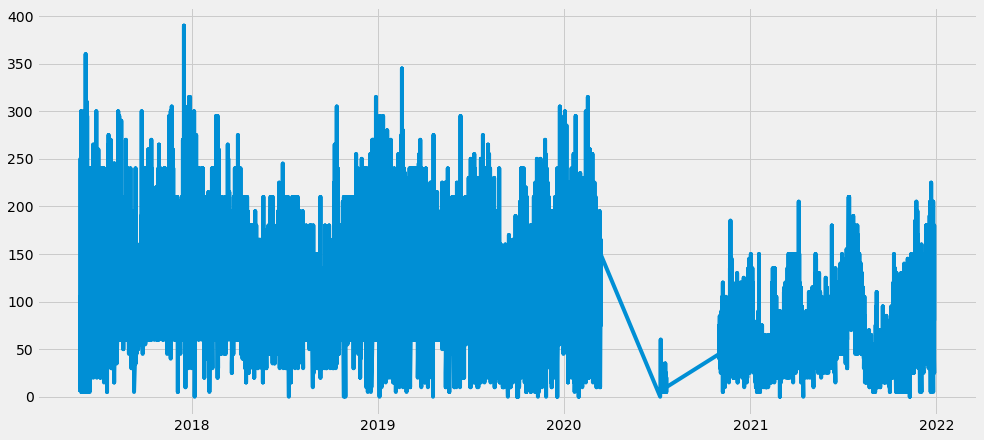

In [5]:
# Plot all wait times
plt.figure(figsize = (15, 7))
plt.plot(flight_posted['SPOSTMIN']);

In [6]:
print(f"Minimum Wait: {flight_posted['SPOSTMIN'].min()}")
print(f"Maximum Wait: {flight_posted['SPOSTMIN'].max()}")

Minimum Wait: 0.0
Maximum Wait: 390.0


In [7]:
flight_posted.tail(250)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name
date,,,,,
2021-12-27,2021-12-27 08:13:36,NaN,115.0,1,Monday
2021-12-27,2021-12-27 08:20:01,NaN,115.0,1,Monday
2021-12-27,2021-12-27 08:23:22,NaN,135.0,1,Monday
2021-12-27,2021-12-27 08:30:01,NaN,135.0,1,Monday
2021-12-27,2021-12-27 08:35:01,NaN,135.0,1,Monday
...,...,...,...,...,...
2021-12-28,2021-12-28 19:35:47,NaN,90.0,2,Tuesday
2021-12-28,2021-12-28 19:42:15,NaN,90.0,2,Tuesday
2021-12-28,2021-12-28 19:48:15,NaN,90.0,2,Tuesday


Because of missing data and the covid closure (March 15 - July 11, 2020), I'm separating the precovid data from the covid data.  Because covid began affecting tourism prior to Disney's official closure, "precovid" is defined as prior to January 1, 2019.

In [8]:
precovid_daily.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
0,2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,2017-05-26
1,2017-05-26,2017-05-26 09:17:09,NaN,60.0,5,Friday,2017-05-26
2,2017-05-26,2017-05-26 09:24:07,NaN,60.0,5,Friday,2017-05-26
3,2017-05-26,2017-05-26 09:30:10,NaN,60.0,5,Friday,2017-05-26
4,2017-05-26,2017-05-26 09:38:10,NaN,45.0,5,Friday,2017-05-26


In [9]:
# Limit data to precovid
precovid_daily = precovid_daily[precovid_daily.date2 < '2019-01-01']
precovid_daily.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_wait
precovid_daily['avg_daily_wait'] = precovid_daily.groupby('date2')['SPOSTMIN'].mean()
precovid_daily = precovid_daily.drop_duplicates(subset='date2', keep='last')
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2017-05-26,2017-05-26 21:38:54,NaN,10.0,5,Friday,2017-05-26,45.866667
2017-05-27,2017-05-27 23:59:09,NaN,90.0,6,Saturday,2017-05-27,196.302521
2017-05-28,2017-05-28 23:30:13,NaN,180.0,7,Sunday,2017-05-28,190.689655
2017-05-29,2017-05-30 00:52:10,NaN,70.0,1,Monday,2017-05-29,141.744186
2017-05-30,2017-05-31 00:52:05,NaN,40.0,2,Tuesday,2017-05-30,154.160305


In [10]:
# Perform same operations on covid data for testing
covid.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_posted_wait
covid['avg_daily_wait'] = covid.groupby('date2')['SPOSTMIN'].mean()
covid = covid.drop_duplicates(subset='date2', keep='last')
covid.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,165.0,2,Tuesday,2019-07-16,158.030303
2019-07-17,2019-07-17 23:38:02,NaN,10.0,3,Wednesday,2019-07-17,116.391304
2019-07-18,2019-07-18 23:59:01,NaN,80.0,4,Thursday,2019-07-18,125.593220
2019-07-19,2019-07-19 21:59:02,NaN,105.0,5,Friday,2019-07-19,133.288288
2019-07-20,2019-07-20 21:59:02,NaN,115.0,6,Saturday,2019-07-20,146.991870


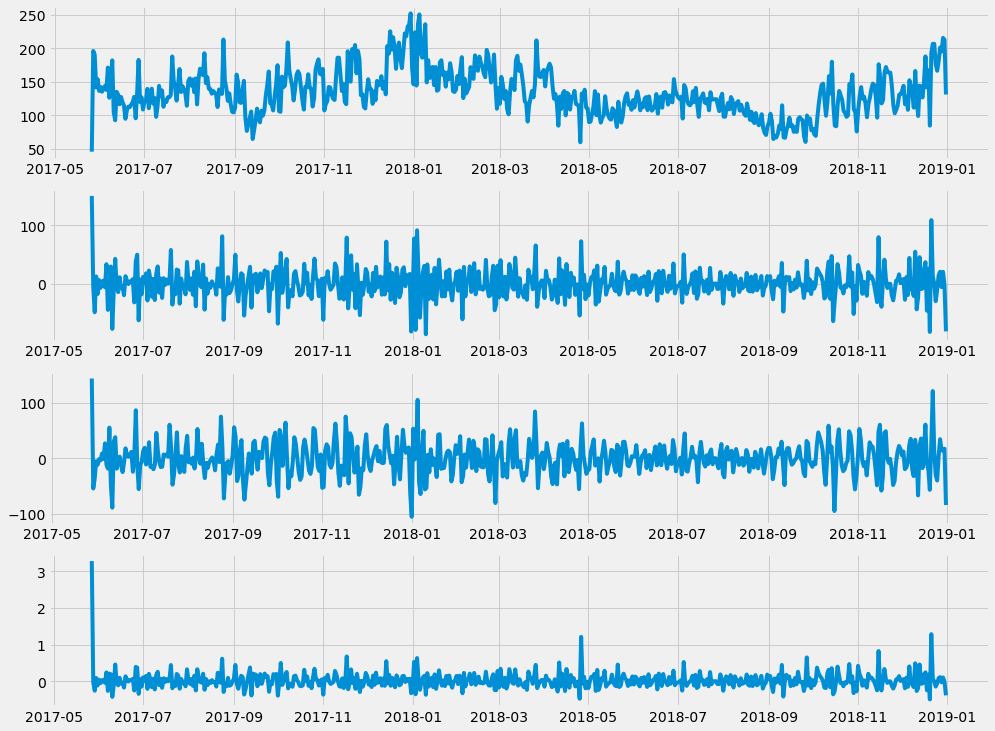

In [11]:
fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
axes[0].plot(precovid_daily['avg_daily_wait'])
axes[1].plot(precovid_daily['avg_daily_wait'].diff())
axes[2].plot(precovid_daily['avg_daily_wait'].diff(2))
axes[3].plot(precovid_daily['avg_daily_wait'].pct_change());

Top plot: Daily mean wait time
2nd plot: Daily mean wait time differenced once
3rd plot: Daily mean wait time differenced twice
4th plot: Percent change of daily mean wait time

There are some indications of seasonality.  Note that time 0 = the day the ride opened, so that can be ignored.  But there are spikes in December, 2017 and December, 2018.

The 4th plot (percent difference) shows minimal differences over days, months, and years.

Ultimately, there is a little evidence of seasonality (Xmas) that I will investigate further in the modeling section.

Unlike Navi River Journey, wait times for Flight of Passage are pretty consistent.  I only need to investigate annual seasonality.  That said, given gaps in the data, this could prove challenging.

### Covid vs. Precovid

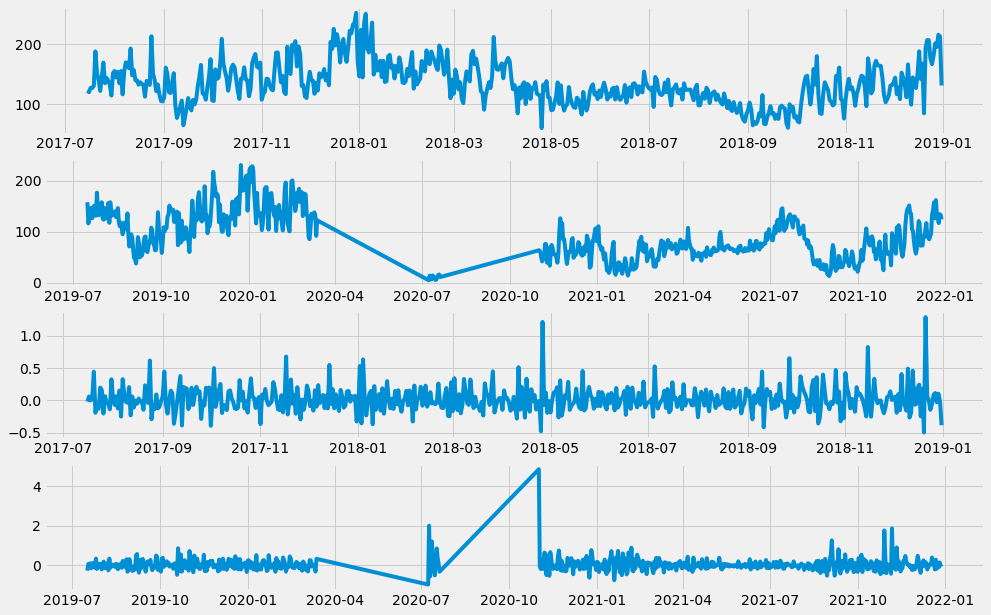

In [12]:
# to facilitate comparison, I'm starting both datasets at the same month for these plots.

precovid_daily_July = precovid_daily[precovid_daily['date2'] > '2017-07-14']

fig, axes = plt.subplots(nrows = 4, figsize = (15, 10))
axes[0].plot(precovid_daily_July['avg_daily_wait'])
axes[1].plot(covid['avg_daily_wait'])
axes[2].plot(precovid_daily_July['avg_daily_wait'].pct_change())
axes[3].plot(covid['avg_daily_wait'].pct_change());

## Day of the Week Seasonality

I would expect longer wait times on weekends, when locals and especially annual passholders are most likely to visit the park.  This is likely to have changed during covid after annual pass rules changed in 2021.

In 2021, Disney overhauled their annual passholder program.  In addition to steep price hikes, they require reservations for annual pass holders to ensure they won't exceed their lower park capacity (anywhere from  25%-50% of regular capacity, depending on the timing of the visit and the pandemic).  Reservations do not cost extra, but lower level passholders have limits on the number of reservations they can make each month; they also have additional blockout dates they never had before.

In [13]:
# Check for Seasonality Based on Day of the week
# Calculate average daily wait based on day of the week (all Mondays, etc.)

av_wait_by_day_of_week = precovid_daily.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       140.815799
Monday       135.538617
Saturday     142.403406
Sunday       131.637887
Thursday     135.675477
Tuesday      131.461024
Wednesday    121.163457
Name: avg_daily_wait, dtype: float64

Average daily wait time for Flight of Passage was over 2 hours before COVID.  Longest waits were experienced on Saturdays (2 hours and 22 min).  Based on this summary, Wednesdays have the shortest average wait and Saturdays have the longest.  However, when ride waits exceed 2 hours, do 20 minutes make a substantial, qualitative difference to riders?  Or are they more likely to opt out or buy an individual Lightning Lane pass to skip the line?

In [14]:
# Covid-era seasonality based on day of the week
av_wait_by_day_of_week = covid.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       89.244019
Monday       90.854888
Saturday     97.370724
Sunday       97.212048
Thursday     82.158707
Tuesday      88.618413
Wednesday    83.396338
Name: avg_daily_wait, dtype: float64

## Hourly Seasonality

Is there a time of day when the ride has significantly shorter or longer wait times?  I'll examine data for a Wednesday (when the average wait was shortest) and a Saturday (when average wait was longest) and look for hourly trends.

In [15]:
# Step 1: Filter data for one day
# This was the Wednesday after Thanksgiving, 2018

flight_Wed_Dec_05 = precovid[precovid['date'] == '2018-12-5']
flight_Wed_Dec_05.set_index('datetime', inplace = True)

In [16]:
print(f"Minimum wait: {flight_Wed_Dec_05['SPOSTMIN'].min()}")
print(f"Maximum wait: {flight_Wed_Dec_05['SPOSTMIN'].max()}")

Minimum wait: 60.0
Maximum wait: 170.0


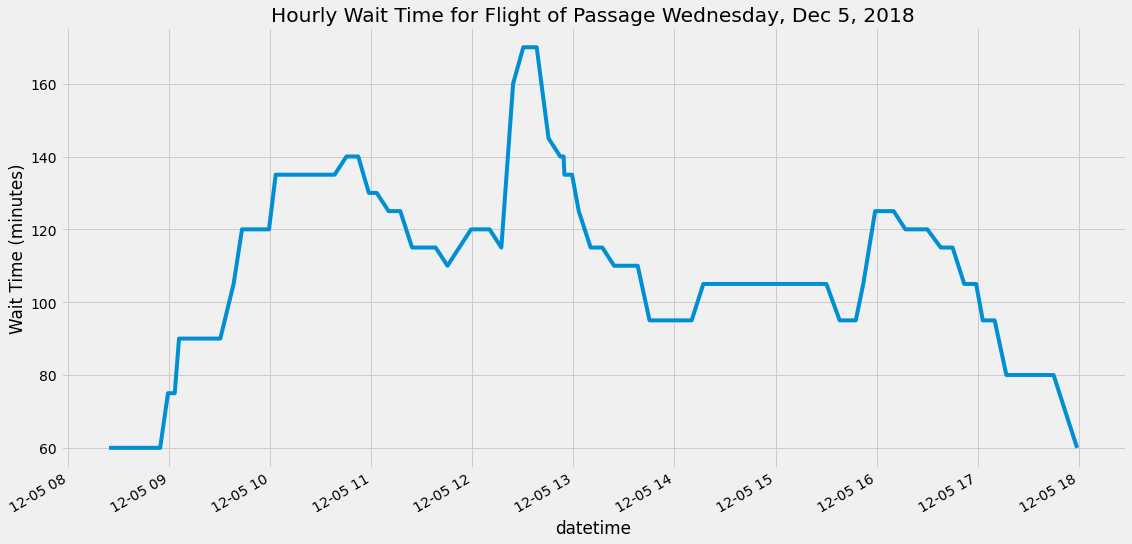

In [17]:
# Step 2: Plot hourly data for Wednesday, Dec 5, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Flight of Passage Wednesday, Dec 5, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')

# Set title and labels for axes

flight_Wed_Dec_05['SPOSTMIN'].plot();

Looking at this low-volume Wednesday indicates that waiting less than an hour without a Lightning Pass is unlikely, at best.

In [18]:
# Step 3: Create data for Saturday, Dec 8, 2018

flight_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
flight_Sat_Dec_08.set_index('datetime', inplace = True)

The hourly plots plots for Wednesday (above) and Saturday (top plot below) differ, but perhaps not in a qualitatively meaningful way.  On Wednesday, Dec 5, 2018 wait times spiked after lunch and dipped from 2-4pm.  However, even with the dip, wait times exceeded 1.5 hours.  I'm interested in learning how many people are willing to wait 90 minutes and how many would spend $15 per person to skip the line.  Since I do not work for Disney, I lack access to that data.  However, given their recent shift to Lightning Lane passes, I'm guessing that Disney has that data and that plenty of people are willing to spend the money.

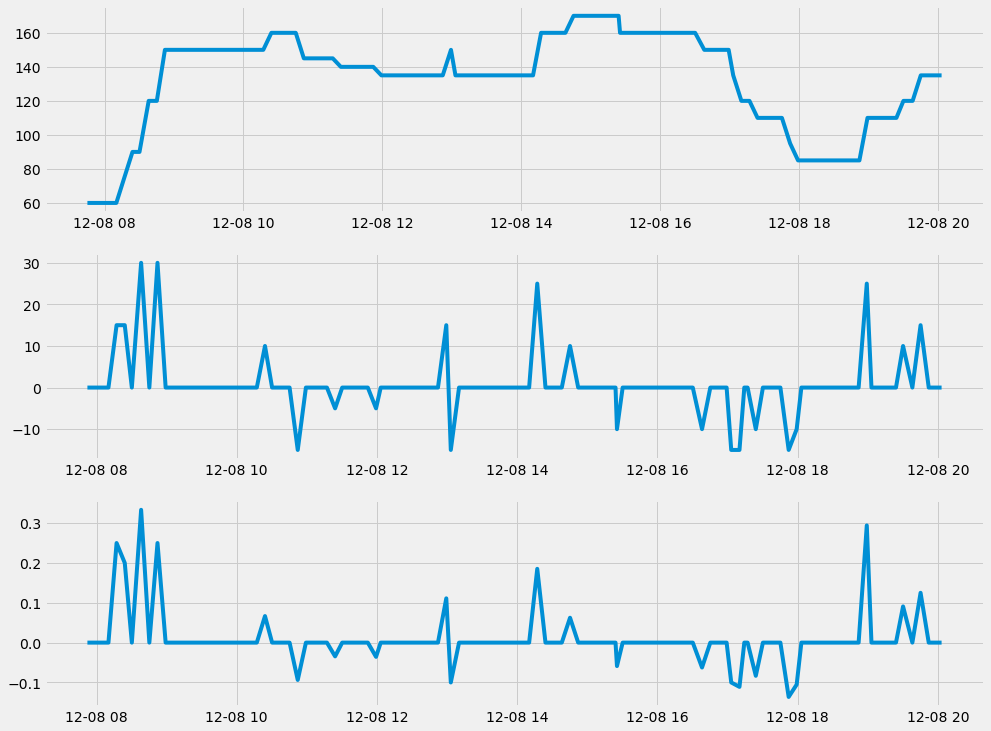

In [19]:
# Step 4: Plot hourly data for Saturday, Dec 8, 2018

# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(flight_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(flight_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(flight_Sat_Dec_08['SPOSTMIN'].pct_change());

In [20]:
print(f"Minimum wait: {flight_Sat_Dec_08['SPOSTMIN'].min()}")
print(f"Maximum wait: {flight_Sat_Dec_08['SPOSTMIN'].max()}")

Minimum wait: 60.0
Maximum wait: 170.0


The second and third subplots show differenced data and percent change data respectively.  The differenced data still show the dips evident in the original data.  The bottom two subplots look very similar.  The data are not stationary for Saturday, Dec 8, 2018.

Comparing these two days provided no additional insight.  I need to compare all Saturdays to all Wednesdays to get a better idea if hourly seasonality exists.

In [21]:
# Step 5: Create df for Saturdays only
flight_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
saturdays = precovid.copy()

saturdays = saturdays[saturdays['day_name'] == 'Saturday']
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
75,2017-05-27,2017-05-27 07:17:06,NaN,60.0,6,Saturday
76,2017-05-27,2017-05-27 07:24:09,NaN,90.0,6,Saturday
77,2017-05-27,2017-05-27 07:30:11,NaN,90.0,6,Saturday
78,2017-05-27,2017-05-27 07:38:05,NaN,90.0,6,Saturday
79,2017-05-27,2017-05-27 07:52:05,NaN,120.0,6,Saturday


In [22]:
# Step 6: Create df for Wednesdays only
wednesdays = precovid.copy()

wednesdays = wednesdays[wednesdays['day_name'] == 'Wednesday']
wednesdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
570,2017-05-31,2017-05-31 07:45:13,NaN,30.0,3,Wednesday
571,2017-05-31,2017-05-31 07:52:07,NaN,30.0,3,Wednesday
572,2017-05-31,2017-05-31 07:55:34,NaN,30.0,3,Wednesday
573,2017-05-31,2017-05-31 07:59:12,NaN,60.0,3,Wednesday
574,2017-05-31,2017-05-31 08:03:13,NaN,60.0,3,Wednesday


In [23]:
import time

saturdays['time'] = [d.time() for d in saturdays['datetime']]
wednesdays['time'] = [d.time() for d in wednesdays['datetime']]

In [24]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
75,2017-05-27,2017-05-27 07:17:06,NaN,60.0,6,Saturday,07:17:06
76,2017-05-27,2017-05-27 07:24:09,NaN,90.0,6,Saturday,07:24:09
77,2017-05-27,2017-05-27 07:30:11,NaN,90.0,6,Saturday,07:30:11
78,2017-05-27,2017-05-27 07:38:05,NaN,90.0,6,Saturday,07:38:05
79,2017-05-27,2017-05-27 07:52:05,NaN,120.0,6,Saturday,07:52:05


In [25]:
saturdays.dtypes

date        datetime64[ns]
datetime    datetime64[ns]
SACTMIN            float64
SPOSTMIN           float64
weekday              int64
day_name            string
time                object
dtype: object

In [26]:
temp_time = datetime.strptime('08:00:00', '%H:%M:%S').time()
saturdays = saturdays[saturdays['time'] > temp_time]
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
80,2017-05-27,2017-05-27 08:03:05,NaN,195.0,6,Saturday,08:03:05
81,2017-05-27,2017-05-27 08:10:16,NaN,195.0,6,Saturday,08:10:16
82,2017-05-27,2017-05-27 08:17:08,NaN,195.0,6,Saturday,08:17:08
83,2017-05-27,2017-05-27 08:24:11,NaN,195.0,6,Saturday,08:24:11
84,2017-05-27,2017-05-27 08:30:13,NaN,195.0,6,Saturday,08:30:13


In [27]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
80,2017-05-27,2017-05-27 08:03:05,NaN,195.0,6,Saturday,08:03:05
81,2017-05-27,2017-05-27 08:10:16,NaN,195.0,6,Saturday,08:10:16
82,2017-05-27,2017-05-27 08:17:08,NaN,195.0,6,Saturday,08:17:08
83,2017-05-27,2017-05-27 08:24:11,NaN,195.0,6,Saturday,08:24:11
84,2017-05-27,2017-05-27 08:30:13,NaN,195.0,6,Saturday,08:30:13


In [28]:
temp_time = datetime.strptime('08:00:00', '%H:%M:%S').time()
wednesdays = wednesdays[wednesdays['time'] > temp_time]
wednesdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
574,2017-05-31,2017-05-31 08:03:13,NaN,60.0,3,Wednesday,08:03:13
575,2017-05-31,2017-05-31 08:10:10,NaN,120.0,3,Wednesday,08:10:10
576,2017-05-31,2017-05-31 08:24:10,NaN,200.0,3,Wednesday,08:24:10
577,2017-05-31,2017-05-31 08:30:15,NaN,250.0,3,Wednesday,08:30:15
578,2017-05-31,2017-05-31 08:38:11,NaN,295.0,3,Wednesday,08:38:11


In [29]:
# resample to 10 min intervals to drop seconds and standardize across Saturdays
saturdays.set_index('datetime', inplace=True)
saturdays.resample('10min', loffset=pd.Timedelta('10min'))


/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_9346/2061199249.py:3: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  saturdays.resample('10min', loffset=pd.Timedelta('10min'))


In [30]:
saturdays.dtypes

date        datetime64[ns]
SACTMIN            float64
SPOSTMIN           float64
weekday              int64
day_name            string
time                object
dtype: object

In [31]:
saturdays.head()

,date,SACTMIN,SPOSTMIN,weekday,day_name,time
datetime,,,,,,
2017-05-27 08:03:05,2017-05-27,NaN,195.0,6,Saturday,08:03:05
2017-05-27 08:10:16,2017-05-27,NaN,195.0,6,Saturday,08:10:16
2017-05-27 08:17:08,2017-05-27,NaN,195.0,6,Saturday,08:17:08
2017-05-27 08:24:11,2017-05-27,NaN,195.0,6,Saturday,08:24:11
2017-05-27 08:30:13,2017-05-27,NaN,195.0,6,Saturday,08:30:13


In [32]:
saturdays.set_index('time', inplace=True)


In [33]:
wednesdays.set_index('datetime', inplace=True)
wednesdays.resample('10min', loffset=pd.Timedelta('10min'))

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_9346/2490914169.py:2: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  wednesdays.resample('10min', loffset=pd.Timedelta('10min'))


In [34]:
wednesdays.head()

,date,SACTMIN,SPOSTMIN,weekday,day_name,time
datetime,,,,,,
2017-05-31 08:03:13,2017-05-31,NaN,60.0,3,Wednesday,08:03:13
2017-05-31 08:10:10,2017-05-31,NaN,120.0,3,Wednesday,08:10:10
2017-05-31 08:24:10,2017-05-31,NaN,200.0,3,Wednesday,08:24:10
2017-05-31 08:30:15,2017-05-31,NaN,250.0,3,Wednesday,08:30:15
2017-05-31 08:38:11,2017-05-31,NaN,295.0,3,Wednesday,08:38:11


In [35]:
wednesdays.set_index('time', inplace=True)

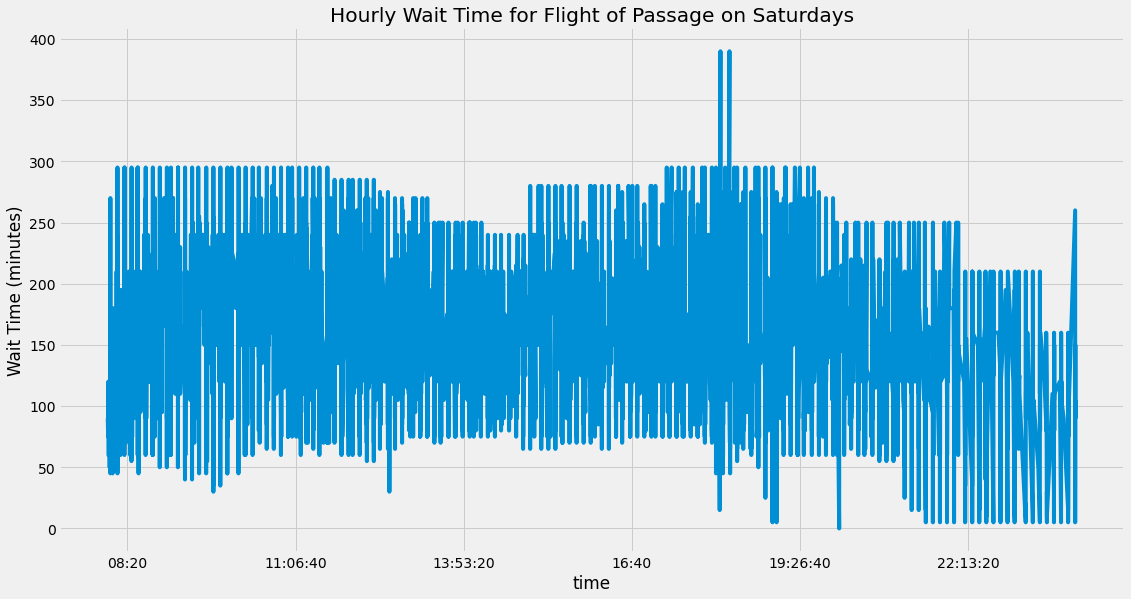

In [36]:
# Step 7: Plot hourly data for all Saturdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Flight of Passage on Saturdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

saturdays['SPOSTMIN'].plot();

The data for Saturday, Dec 8, 2018 showed a dip between 2-4pm.  These data show some odd spiking around 6pm, but overall wait times are flat.

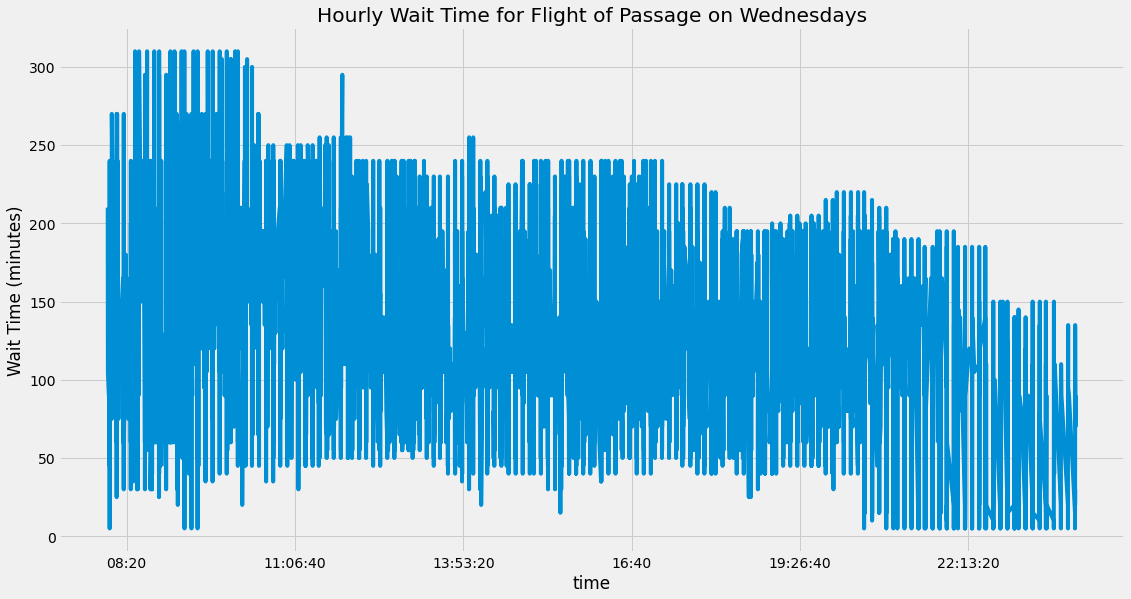

In [37]:
# Step 7: Plot hourly data for all Wednesdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Flight of Passage on Wednesdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

wednesdays['SPOSTMIN'].plot();

Overall, the darker pattern in this plot resembles the darker pattern in the Saturdays plot.  There might be hourly seasonality for this ride, but it's so popular that its wait times are at 2 hours by 9am.  Note that often the park opens at 9am.  In a few years, once the ride is no longer new, hourly seasonality might be something to revisit.  Currently, there might be some minor hourly patterns, but wait times are high throughout the day.  Also note that park hours differ depending on the time of year.  Even when the park is open until 10pm or later (this is very uncommon), wait times remain over 2 hours.

## Weekly Seasonality

Weekly seasonality must be considered, but it's tricky because spring break and Thanksgiving dates shift each year.  Spring break dates can shift by as much as 6 weeks.  Therefore, a customized approach is warranted.

First, I'll number each week of the year, beginning with the day after the Christmas - New Year's blockout dates end.  Week numbers for the first year will align with the calendar, aside from the brief offset for New Year's blockout dates.  For subsequent years, spring break weeks - as defined by Disney's blockout dates - will be switched to align with the first years.  In other words, spring breaks will always have the same week numbers, regardless of where they fall in the calendar.  I'll do the same with Thanksgiving and, if necessary, Christmas.

I realize this isn't a perfect system.  K-12 school districts tend to align to Easter; colleges and universities do not.  However, using Disney's self-declared blockout dates for lower-level passholders makes the system as equivalent as possible.

Another issue with this method is covid's timing.  Flight of Passage opened May 27, 2017, so it was only open for 1.5 years before covid began impacting tourism.  Therefore, for this ride and for Flight of Passage, I'll focus solely on August 1 - Dec 31 of 2017, 2018, 2019, and 2020.

In [38]:
precovid.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
0,2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday
1,2017-05-26,2017-05-26 09:17:09,NaN,60.0,5,Friday
2,2017-05-26,2017-05-26 09:24:07,NaN,60.0,5,Friday
3,2017-05-26,2017-05-26 09:30:10,NaN,60.0,5,Friday
4,2017-05-26,2017-05-26 09:38:10,NaN,45.0,5,Friday


In [39]:
# flight_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']

In [40]:
# copy dataframe for backup
precovid_weekly = precovid_daily.copy()

# create day number
precovid_weekly['day_num'] = range(0, len(precovid_weekly))

# use day number to create and calculate week number
precovid_weekly['week_num'] = (precovid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
precovid_weekly_2 = precovid_weekly.copy()

# Create two copies: one for future indexing and one for other uses
precovid_weekly['week_number'] = precovid_weekly['week_num']

precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_num,week_number
date,,,,,,,,,,
2017-05-26,2017-05-26 21:38:54,NaN,10.0,5,Friday,2017-05-26,45.866667,0,0,0
2017-05-27,2017-05-27 23:59:09,NaN,90.0,6,Saturday,2017-05-27,196.302521,1,0,0
2017-05-28,2017-05-28 23:30:13,NaN,180.0,7,Sunday,2017-05-28,190.689655,2,0,0
2017-05-29,2017-05-30 00:52:10,NaN,70.0,1,Monday,2017-05-29,141.744186,3,0,0
2017-05-30,2017-05-31 00:52:05,NaN,40.0,2,Tuesday,2017-05-30,154.160305,4,0,0


In [41]:
# set index to week number
precovid_weekly.set_index('week_num', inplace=True)

# groupby week
precovid_weekly['avg_weekly_wait'] = precovid_weekly.groupby('week_num')['avg_daily_wait'].mean()

precovid_weekly['date'] = precovid_weekly['date2']

# set index to date
precovid_weekly.set_index('date', inplace=True)

# delete duplicates
precovid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

precovid_weekly.shape

(84, 10)

In [42]:
precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2017-06-01,2017-06-02 00:45:11,NaN,60.0,4,Thursday,2017-06-01,142.655172,6,0,143.997882
2017-06-08,2017-06-09 00:10:42,NaN,160.0,4,Thursday,2017-06-08,152.888889,13,1,143.923706
2017-06-15,2017-06-16 01:03:06,NaN,90.0,4,Thursday,2017-06-15,127.594937,20,2,127.176590
2017-06-22,2017-06-23 01:03:08,NaN,80.0,4,Thursday,2017-06-22,116.089744,27,3,111.265175
2017-06-29,2017-06-30 01:03:06,NaN,75.0,4,Thursday,2017-06-29,127.147059,34,4,129.546674


In [43]:
# Had to copy data first before limiting by date.  Didn't work when I tried to combine steps.
Aug17 = precovid_weekly.copy()
Aug18 = precovid_weekly.copy()

Aug17 = Aug17[Aug17['date2'] > '2017-07-31']
Aug17 = Aug17[Aug17['date2'] <= '2017-12-31']
Aug18 = Aug18[Aug18['date2'] > '2018-07-31']
Aug18 = Aug18[Aug18['date2'] <= '2018-12-31']

In [44]:
Aug18.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2018-08-04,2018-08-04 21:59:06,NaN,85.0,6,Saturday,2018-08-04,118.646617,433,61,113.050655
2018-08-11,2018-08-11 21:30:10,NaN,160.0,6,Saturday,2018-08-11,121.304348,440,62,116.808820
2018-08-18,2018-08-18 21:30:10,NaN,60.0,6,Saturday,2018-08-18,106.517241,447,63,108.164417
2018-08-25,2018-08-25 21:30:10,NaN,65.0,6,Saturday,2018-08-25,85.370370,454,64,94.263958
2018-09-01,2018-09-01 20:30:10,NaN,65.0,6,Saturday,2018-09-01,89.556452,461,65,84.331185


In [45]:
# Between covid and the ride opening in May, 2017, week_number in all Aug dfs must be 
# calibrated to be in sync with each other

Aug17['week_number'] = Aug17['week_number'] - 9
Aug18['week_number'] = Aug18['week_number'] - 61

In [46]:
Aug18.head(20)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2018-08-04,2018-08-04 21:59:06,NaN,85.0,6,Saturday,2018-08-04,118.646617,433,0,113.050655
2018-08-11,2018-08-11 21:30:10,NaN,160.0,6,Saturday,2018-08-11,121.304348,440,1,116.808820
2018-08-18,2018-08-18 21:30:10,NaN,60.0,6,Saturday,2018-08-18,106.517241,447,2,108.164417
2018-08-25,2018-08-25 21:30:10,NaN,65.0,6,Saturday,2018-08-25,85.370370,454,3,94.263958
2018-09-01,2018-09-01 20:30:10,NaN,65.0,6,Saturday,2018-09-01,89.556452,461,4,84.331185
2018-09-08,2018-09-08 20:30:10,NaN,90.0,6,Saturday,2018-09-08,84.960938,468,5,78.937713
2018-09-15,2018-09-15 20:30:10,NaN,120.0,6,Saturday,2018-09-15,96.598361,475,6,84.126308
2018-09-22,2018-09-22 21:30:10,NaN,60.0,6,Saturday,2018-09-22,97.382812,482,7,84.875715
2018-09-29,2018-09-29 20:30:10,NaN,105.0,6,Saturday,2018-09-29,95.546218,489,8,85.662504


In [47]:
# Thanksgiving, 2017 = Nov 23; Thanksgiving, 2018 = Nov 22.  They have the same week number.

In [48]:
# copy dataframe for backup
covid_weekly = covid.copy()


# create day number
covid_weekly['day_num'] = range(0, len(covid_weekly))

# use day number to create and calculate week number
covid_weekly['week_num'] = (covid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
covid_weekly_2 = covid_weekly.copy()

covid_weekly['week_number'] = covid_weekly['week_num']

# Group waiting times by date to get avg_daily_posted_wait
covid_weekly['avg_daily_wait'] = covid_weekly.groupby('date2')['SPOSTMIN'].mean()

# set index to week number
covid_weekly.set_index('week_num', inplace=True)

# groupby week
covid_weekly['avg_weekly_wait'] = covid_weekly.groupby('week_num')['avg_daily_wait'].mean()

covid_weekly['date'] = covid_weekly['date2']

# set index to date
covid_weekly.set_index('date', inplace=True)

# delete duplicates
covid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

covid_weekly.head()


,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2019-07-22,2019-07-22 23:59:02,NaN,15.0,1,Monday,2019-07-22,15.0,6,0,80.714286
2019-07-29,2019-07-29 23:59:02,NaN,15.0,1,Monday,2019-07-29,15.0,13,1,116.428571
2019-08-05,2019-08-05 23:59:02,NaN,20.0,1,Monday,2019-08-05,20.0,20,2,90.714286
2019-08-12,2019-08-12 23:59:02,NaN,20.0,1,Monday,2019-08-12,20.0,27,3,68.571429
2019-08-19,2019-08-19 23:59:02,NaN,15.0,1,Monday,2019-08-19,15.0,34,4,111.428571


In [49]:
Aug19 = covid_weekly.copy()
Aug20 = covid_weekly.copy()

Aug19 = Aug19[Aug19['date2'] > '2019-07-31']
Aug19 = Aug19[Aug19['date2'] <= '2019-12-31']
Aug20 = Aug20[Aug20['date2'] > '2020-07-31']
Aug20 = Aug20[Aug20['date2'] <= '2020-12-31']

# Offsets needed to sync up Thanksgiving to same week number (roughly)
Aug19['week_number'] = Aug19['week_number'] - 2
Aug20['week_number'] = Aug20['week_number'] - 24

In [50]:
Aug20.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2020-11-04,2020-11-04 17:10:01,NaN,25.0,3,Wednesday,2020-11-04,25.0,258,12,31.428571
2020-11-11,2020-11-11 16:56:59,NaN,45.0,3,Wednesday,2020-11-11,45.0,265,13,41.428571
2020-11-18,2020-11-18 16:59:01,NaN,70.0,3,Wednesday,2020-11-18,70.0,272,14,49.285714
2020-11-25,2020-11-25 20:03:01,NaN,90.0,3,Wednesday,2020-11-25,90.0,279,15,60.714286
2020-12-02,2020-12-02 16:56:39,NaN,50.0,3,Wednesday,2020-12-02,50.0,286,16,42.142857


### Weekly EDA

In [51]:
precovid_weekly.set_index('date2', inplace=True)

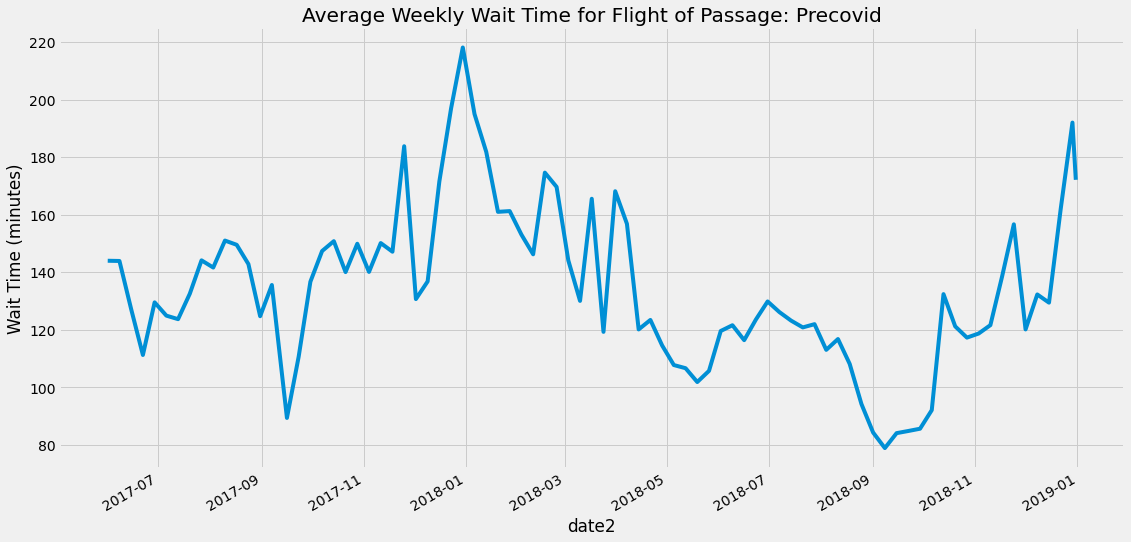

In [52]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time for Flight of Passage: Precovid")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

precovid_weekly['avg_weekly_wait'].plot();

There is definite weekly fluctuation.  The most obvious spikes are in late December of 2017 and 2018.  Late September, 2017 and 2018 had similar dips in wait times.  Still, the shortest wait time was approximately 80 min.

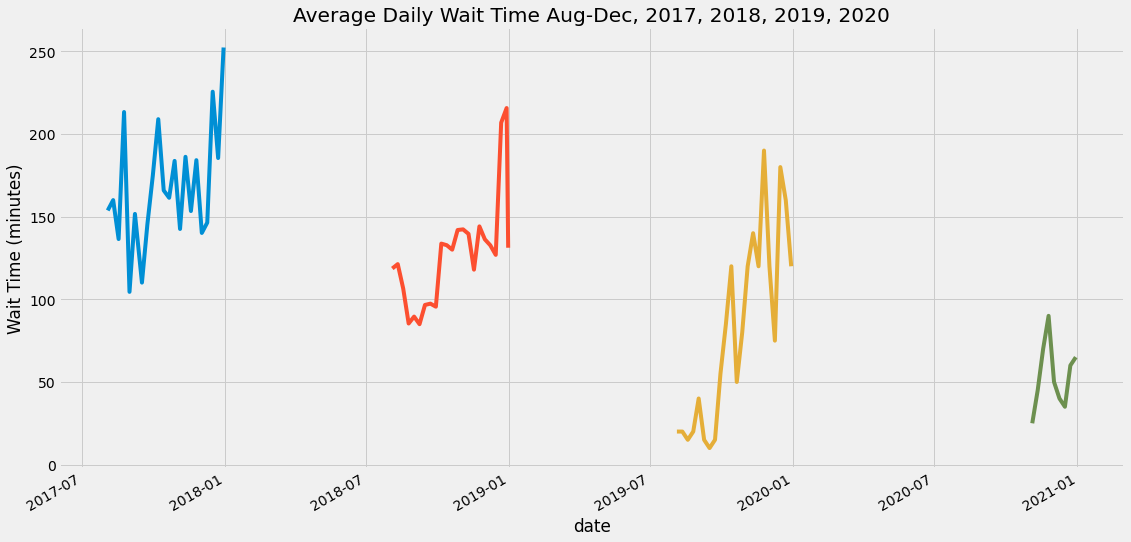

In [53]:
plt.figure(figsize = (17, 9))
plt.title("Average Daily Wait Time Aug-Dec, 2017, 2018, 2019, 2020")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

Aug17['avg_daily_wait'].plot()
Aug18['avg_daily_wait'].plot()
Aug19['avg_daily_wait'].plot()
Aug20['avg_daily_wait'].plot();

The trends appear very similar.  December 2018 and 2020 appear more affected by covid than December 2020.  At least in Autumn, there is seasonality.  The biggest difference among the plots is that average daily wait time decreased each year from 2017-2019 and leveled off in 2020.

In [54]:
Aug17.set_index('week_number', inplace=True)
Aug18.set_index('week_number', inplace=True)
Aug19.set_index('week_number', inplace=True)
Aug20.set_index('week_number', inplace=True)

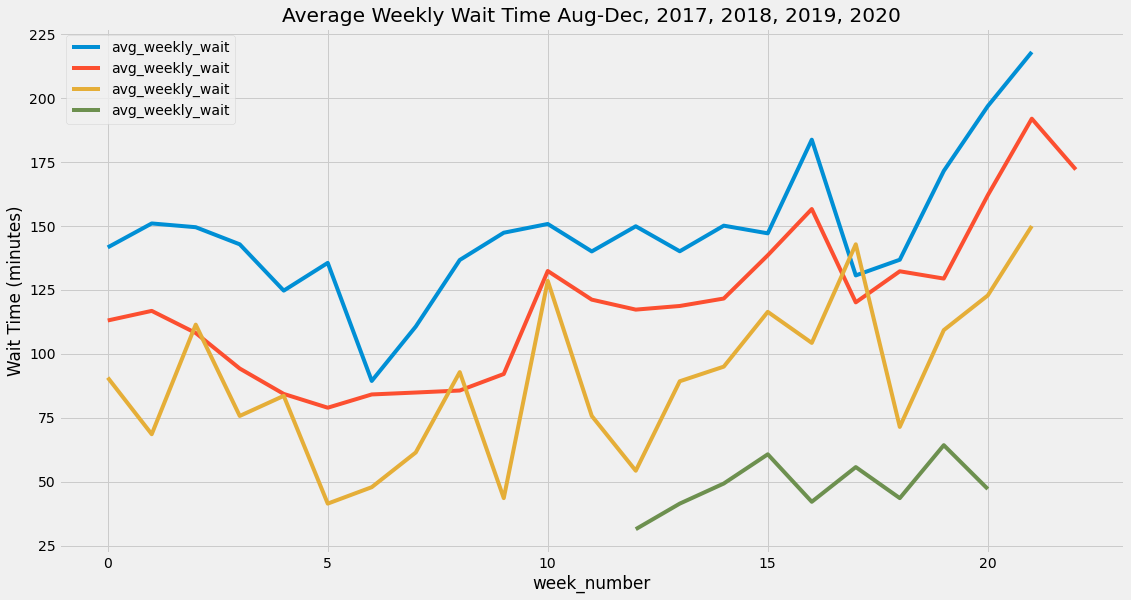

In [55]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time Aug-Dec, 2017, 2018, 2019, 2020")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

Aug17['avg_weekly_wait'].plot()
Aug18['avg_weekly_wait'].plot()
Aug19['avg_weekly_wait'].plot()
Aug20['avg_weekly_wait'].plot()
plt.legend();

By calibrating all years by week number, I can plot the average daily wait times on the same graph.  2017(blue) and 2019 (yelllow) look somewhat similar.  Wait times were higher in 2017, but since the ride was new in 2017, that makes sense.  

2020 (green) is missing a lot of data, but wait times appear to have dropped substantially. 

# Modeling

## Precovid Null Model

In [56]:
# Overall average wait time before covid
precovid['SPOSTMIN'].mean()

133.2992990735279

In this case, the null model is the mean wait time before covid, or 70 minutes.  I calculated this figure using the original data but excluding all dates after March 15, 2020.

In [57]:
precovid_weekly_2 = precovid_weekly.copy()

In [58]:
# for prediction purposes, I want a one year dataset unaffected by covid and the ride's grand opening
precovid_weekly_2 = precovid_weekly_2[precovid_weekly_2['datetime'] > '2017-08-01']
precovid_weekly_2 = precovid_weekly_2[precovid_weekly_2['datetime'] < '2018-08-01']
precovid_weekly_2.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_wait,day_num,week_number,avg_weekly_wait
date2,,,,,,,,,
2017-08-03,2017-08-03 23:59:06,NaN,105.0,4,Thursday,153.776224,69,9,141.639787
2017-08-10,2017-08-11 00:03:07,NaN,60.0,4,Thursday,160.034247,76,10,151.006947
2017-08-17,2017-08-18 00:03:07,NaN,70.0,4,Thursday,136.472603,83,11,149.535727
2017-08-24,2017-08-24 21:30:09,NaN,195.0,4,Thursday,213.320611,90,12,142.842627
2017-08-31,2017-08-31 21:30:10,NaN,105.0,4,Thursday,104.511278,97,13,124.731680


In [59]:
precovid_weekly_2.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_wait,day_num,week_number,avg_weekly_wait
date2,,,,,,,,,
2017-08-03,2017-08-03 23:59:06,NaN,105.0,4,Thursday,153.776224,69,9,141.639787
2017-08-10,2017-08-11 00:03:07,NaN,60.0,4,Thursday,160.034247,76,10,151.006947
2017-08-17,2017-08-18 00:03:07,NaN,70.0,4,Thursday,136.472603,83,11,149.535727
2017-08-24,2017-08-24 21:30:09,NaN,195.0,4,Thursday,213.320611,90,12,142.842627
2017-08-31,2017-08-31 21:30:10,NaN,105.0,4,Thursday,104.511278,97,13,124.731680


## Covid Null Model

In [60]:
# Overall average wait time during covid
covid_null = covid[covid['date2'] < '2021-09-01']
covid_null['SPOSTMIN'].mean()

67.11985688729875

In [61]:
covid.head(3)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,165.0,2,Tuesday,2019-07-16,158.030303
2019-07-17,2019-07-17 23:38:02,NaN,10.0,3,Wednesday,2019-07-17,116.391304
2019-07-18,2019-07-18 23:59:01,NaN,80.0,4,Thursday,2019-07-18,125.593220


## ACF and PACF Plots

### 1 Year Plots

All of these plots use data that starts in August, 2017.

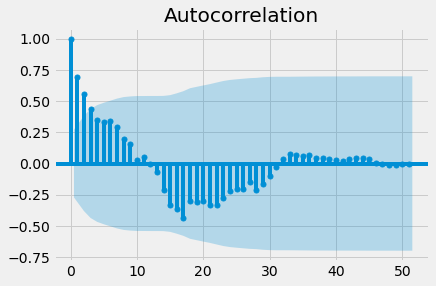

In [62]:
# Weekly ACF plot for May 26, 2017 - May 26, 2018: pre-covid
# X-axis = week number
plot_acf(precovid_weekly_2['avg_weekly_wait'], lags=51)
plt.show()

This plot shows indications of seasonality, with significant autocorrelation for almost 4 weeks, followed by what looks like a subtle cosine curve.

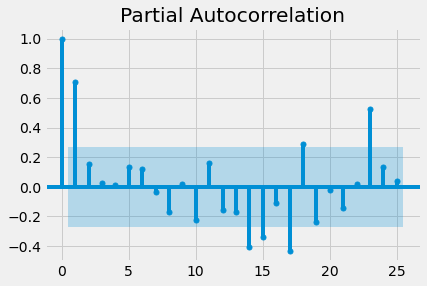

In [63]:
# Weekly PACF plot for May 26, 2017 - May 26, 2018: pre-covid
plot_pacf(precovid_weekly_2['avg_weekly_wait'], lags=25)
plt.show()

The partial autocorrelation plot also shows a few indications of seasonality, with spikes at interval 18 and 23.

### 90 Day ACF and PACF Plots

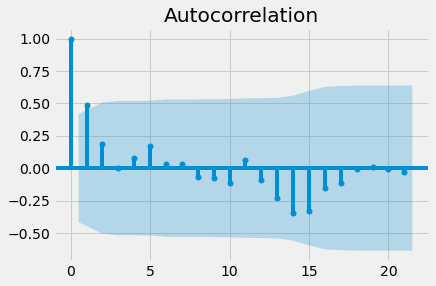

In [64]:
# 5 month plot, beginning Aug 1, 2017 (roughly 5 months)
plot_acf(Aug17['avg_weekly_wait'], lags=21)
plt.show()

There's really no evidence of autocorrelation here.  The fluctuation is not significant after the second week.

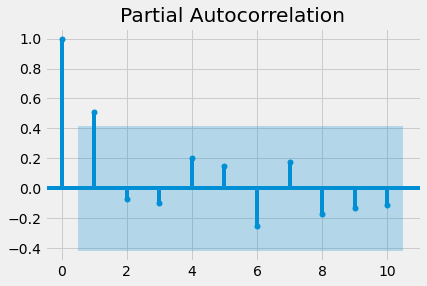

In [65]:
# 13 Week plot beginning Aug 1, 2017 (roughly 3 months)
plot_pacf(Aug17['avg_weekly_wait'], lags=10)
plt.show()

Partial autocorrelation is only observed the first two weeks (as expected).

In [66]:
Aug18.head(25)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,avg_weekly_wait
week_number,,,,,,,,,
0,2018-08-04 21:59:06,NaN,85.0,6,Saturday,2018-08-04,118.646617,433,113.050655
1,2018-08-11 21:30:10,NaN,160.0,6,Saturday,2018-08-11,121.304348,440,116.808820
2,2018-08-18 21:30:10,NaN,60.0,6,Saturday,2018-08-18,106.517241,447,108.164417
3,2018-08-25 21:30:10,NaN,65.0,6,Saturday,2018-08-25,85.370370,454,94.263958
4,2018-09-01 20:30:10,NaN,65.0,6,Saturday,2018-09-01,89.556452,461,84.331185
5,2018-09-08 20:30:10,NaN,90.0,6,Saturday,2018-09-08,84.960938,468,78.937713
6,2018-09-15 20:30:10,NaN,120.0,6,Saturday,2018-09-15,96.598361,475,84.126308
7,2018-09-22 21:30:10,NaN,60.0,6,Saturday,2018-09-22,97.382812,482,84.875715
8,2018-09-29 20:30:10,NaN,105.0,6,Saturday,2018-09-29,95.546218,489,85.662504


### Decomposition

In [67]:
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2017-05-26,2017-05-26 21:38:54,NaN,10.0,5,Friday,2017-05-26,45.866667
2017-05-27,2017-05-27 23:59:09,NaN,90.0,6,Saturday,2017-05-27,196.302521
2017-05-28,2017-05-28 23:30:13,NaN,180.0,7,Sunday,2017-05-28,190.689655
2017-05-29,2017-05-30 00:52:10,NaN,70.0,1,Monday,2017-05-29,141.744186
2017-05-30,2017-05-31 00:52:05,NaN,40.0,2,Tuesday,2017-05-30,154.160305


<Figure size 432x288 with 0 Axes>

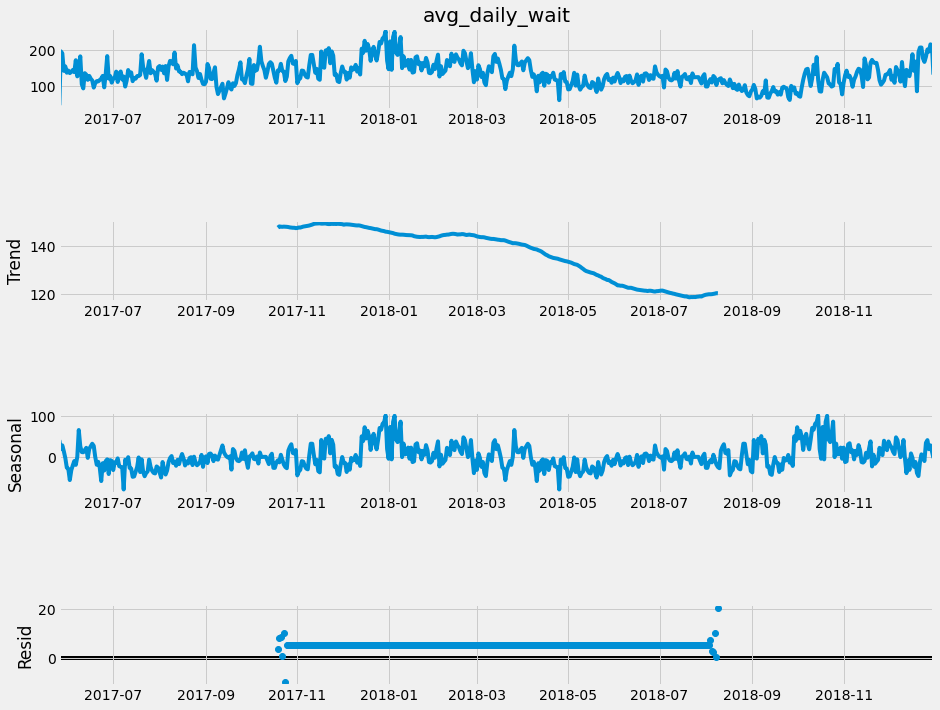

In [68]:
# Daily seasonality?

decomp_daily = seasonal_decompose(precovid_daily.avg_daily_wait, period = 289)
fig = plt.figure()
fig = decomp_daily.plot()
fig.set_size_inches(15, 12);

Decomposition of average daily wait times shows minimal seasonality at most.  Overally, wait times are decreasing over time.  This was not visible in previous plots.

Residuals are minimal, so any prediction models should be pretty accurate.

<Figure size 432x288 with 0 Axes>

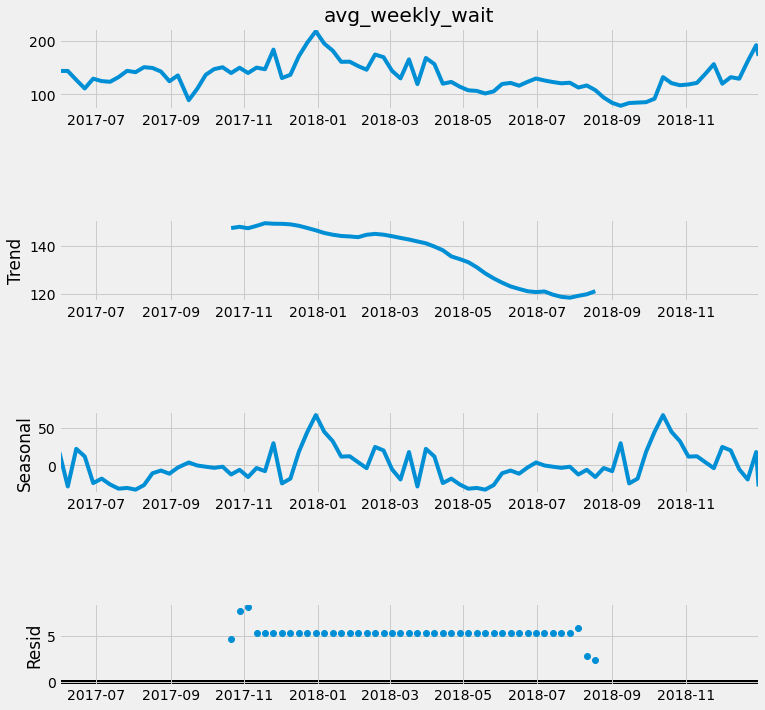

In [69]:
# Weekly seasonality?

decomp_weekly = seasonal_decompose(precovid_weekly.avg_weekly_wait, period = 41)
fig = plt.figure()
fig = decomp_weekly.plot()
fig.set_size_inches(12, 12);


The weekly decomposition plots look very similar to the daily decomposition plots.  The daily decomposition doesn't add any granularity.

In [70]:
precovid_weekly_3 = pd.DataFrame(precovid_weekly['avg_weekly_wait'])

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
precovid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

,avg_weekly_wait
date2,
2017-06-01,143.997882
2017-06-08,143.923706
2017-06-15,127.176590
2017-06-22,111.265175
2017-06-29,129.546674
...,...
2018-11-29,130.572924
2018-12-06,128.823594
2018-12-13,130.258222


In [71]:
covid_weekly_3 = pd.DataFrame(covid_weekly['avg_weekly_wait'])

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
covid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

,avg_weekly_wait
date,
2019-07-22,80.714286
2019-07-29,116.428571
2019-08-05,90.714286
2019-08-12,68.571429
2019-08-19,111.428571
...,...
2021-11-29,93.979592
2021-12-06,77.653061
2021-12-13,85.816327


In [72]:
# covid_weekly_3 = pd.DataFrame(covid_weekly['avg_weekly_wait'])

In [73]:
#covid.tail(50)

There are insufficient data and too many large gaps to predict wait times on a weekly basis, so I must use daily data.  The next question is which "precovid" data to use: 2018, 2019, or 2020?  The parks were closed from mid-March - mid-July, 2019.  Disney is still not running at full capacity, so if those data are availble, they might predict wait times better than 2018 data.  I lack the data for 2020, so that's not an option.

## Predict Wait Times for Autumn, 2021

### Option 1 (Null Model):
Remember, the null model is that guests will wait 29 minutes to ride this ride.

### Option 2: ARIMA

In [74]:
# Modify dfs to make them the same length[Aug 30 - Oct 31, 2021 & Aug 30 - Oct 31, 2019]
y_train = covid[covid['date2'] > '2019-08-29']
y_train = y_train[y_train['date2'] < '2019-12-29']
y_test = covid[covid['date2'] > '2021-08-29']

In [75]:
y_train.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-08-30,2019-08-30 21:24:02,NaN,75.0,5,Friday,2019-08-30,93.277311
2019-08-31,2019-08-31 21:31:02,NaN,70.0,6,Saturday,2019-08-31,94.833333
2019-09-01,2019-09-01 21:24:02,NaN,60.0,7,Sunday,2019-09-01,89.110169
2019-09-02,2019-09-02 21:31:02,NaN,40.0,1,Monday,2019-09-02,64.708333
2019-09-03,2019-09-03 13:59:02,NaN,60.0,2,Tuesday,2019-09-03,48.196721


In [76]:
y_test.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2021-08-30,2021-08-30 18:59:07,NaN,10.0,1,Monday,2021-08-30,16.818182
2021-08-31,2021-08-31 19:02:10,NaN,10.0,2,Tuesday,2021-08-31,16.764706
2021-09-01,2021-09-01 18:59:07,NaN,15.0,3,Wednesday,2021-09-01,12.688679
2021-09-02,2021-09-02 18:59:07,NaN,10.0,4,Thursday,2021-09-02,16.904762
2021-09-03,2021-09-03 18:59:08,NaN,25.0,5,Friday,2021-09-03,26.435185


Aug 30, 2019 was a Friday; Aug 30, 2021 was a Monday.  I need to modify the dataframes and index them by day_number (new field), so that the days of the week match up, even though actual dates will differ by a few days.

I would start y_train on Monday, Sept 2, 2019 instead of August 30, but that was Labor Day. Sept 6, 2021 was Labor Day.  There's no perfect way to adjust for this.  I'll manually recode the respective dates as Sundays instead of Mondays to predict crowds better.  The plots won't match, but in the final analysis (predicting actual wait times vs predicted), it will be fine.

In [77]:
# Add day_number and make it index in both dfs

y_train['day_number'] = range(1, 1 + len(y_train))
y_test['day_number'] = range(1, 1 + len(y_test))

y_train.set_index('day_number', inplace=True)
y_test.set_index('day_number', inplace=True)

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_9346/3422483454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['day_number'] = range(1, 1 + len(y_test))


In [78]:
y_train

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
day_number,,,,,,,
1,2019-08-30 21:24:02,NaN,75.0,5,Friday,2019-08-30,93.277311
2,2019-08-31 21:31:02,NaN,70.0,6,Saturday,2019-08-31,94.833333
3,2019-09-01 21:24:02,NaN,60.0,7,Sunday,2019-09-01,89.110169
4,2019-09-02 21:31:02,NaN,40.0,1,Monday,2019-09-02,64.708333
5,2019-09-03 13:59:02,NaN,60.0,2,Tuesday,2019-09-03,48.196721
...,...,...,...,...,...,...,...
117,2019-12-24 20:59:02,NaN,215.0,2,Tuesday,2019-12-24,231.200000
118,2019-12-25 20:59:02,NaN,180.0,3,Wednesday,2019-12-25,184.612069
119,2019-12-26 20:59:02,NaN,105.0,4,Thursday,2019-12-26,180.648148


In [79]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 1 to 121
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        121 non-null    datetime64[ns]
 1   SACTMIN         0 non-null      float64       
 2   SPOSTMIN        121 non-null    float64       
 3   weekday         121 non-null    int64         
 4   day_name        121 non-null    string        
 5   date2           121 non-null    datetime64[ns]
 6   avg_daily_wait  121 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(1), string(1)
memory usage: 7.6 KB


In [80]:
# For use in future, calculating MAE and MSE
both_models = y_test.copy()

In [81]:
# These are daily data.
y_train = pd.DataFrame(y_train['avg_daily_wait'])
y_test = pd.DataFrame(y_test['avg_daily_wait'])

In [82]:
# From lesson 9.3, Hank Butler
# start with really high AIC, initialize p and q to zero
# loop through to find best aic, p, and q
# Starting AIC, p, and q.

best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):

        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = y - variable
                         order = (p, 1, q)) # values of p, d, q
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index

Attempting to fit ARIMA(0, 1, 0)


 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12
The AIC for ARIMA(0,1,0) is: 1121.1454713984945
At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65477D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   4.655D+00
  F =   4.6547727974937265     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

Attempting to fit ARIMA(0, 1, 1)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56402D+00    |proj g|=  4.75990D-02

At iterate    5    f=  4.55904D+00    |proj g|=  7.62794D-03

At iterate   10    f=  4.55675D+00    |proj g|=  1.39204D-03

At iterate   15    f=  4.55663D+00    |proj g|=  2.44693D-04

At iterate   20    f=  4.55662D+00    |proj g|=  7.03437D-05

At iterate   25    f=  4.55662D+00    |proj g|=  9.32587D-05

At iterate   30    f=  4.55662D+00    |proj g|=  6.21725D-07
  ys=-3.176E-12  -gs= 5.969E-12 BFGS update SKIPPED

At iterate   35    f=  4.55662D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

The AIC for ARIMA(1,1,1) is: 1101.830110493004
Attempting to fit ARIMA(1, 1, 2)
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(2, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60984D+00    |proj g|=  1.16831D-03

At iterate    5    f=  4.60983D+00    |proj g|=  2.94076D-04

At iterate   10    f=  4.60983D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   1.776D-

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56138D+00    |proj g|=  6.52809D-02

At iterate    5    f=  4.55216D+00    |proj g|=  1.00062D-03

At iterate   10    f=  4.55212D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   8.882D-08   4.552D+00
  F =   4.5521217428997067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,2) is: 1104.5092182959297
Attempting to fit ARIM

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index w

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57268D+00    |proj g|=  2.26929D-02

At iterate    5    f=  4.55999D+00    |proj g|=  3.88082D-02

At iterate   10    f=  4.55490D+00    |proj g|=  1.44853D-03

At iterate   15    f=  4.55477D+00    |proj g|=  3.49765D-04

At iterate   20    f=  4.55476D+00    |proj g|=  2.11386D-05

At iterate   25    f=  4.55476D+00    |proj g|=  4.76064D-05

At iterate   30    f=  4.55476D+00    |proj g|=  1.39444D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.



At iterate   25    f=  4.54777D+00    |proj g|=  9.27614D-04

At iterate   30    f=  4.54774D+00    |proj g|=  1.23279D-04

At iterate   35    f=  4.54773D+00    |proj g|=  1.13687D-05

At iterate   40    f=  4.54773D+00    |proj g|=  3.21521D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     70      1     0     0   8.438D-06   4.548D+00
  F =   4.5477336780962059     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,2) is: 1105.4560827430894
Attempting to fit ARIMA(3, 1, 3)



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57640D+00    |proj g|=  1.01864D+00

At iterate    5    f=  4.54254D+00    |proj g|=  2.70044D-02

At iterate   10    f=  4.54125D+00    |proj g|=  4.91829D-03

At iterate   15    f=  4.54097D+00    |proj g|=  2.16108D-02

At iterate   20    f=  4.54065D+00    |proj g|=  5.69776D-02

At iterate   25    f=  4.53933D+00    |proj g|=  2.81102D-02

At iterate   30    f=  4.53920D+00    |proj g|=  1.45306D-03

At iterate   35    f=  4.53920D+00    |proj g|=  6.89226D-05

At iterate   40    f=  4.53920D+00    |proj g|=  8.34888D-06
  ys=-3.271E-11  -gs= 1.448E-12 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and wi


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43    103      2     1     0   1.210D-04   4.539D+00
  F =   4.5391986471358488     

ABNORMAL_TERMINATION_IN_LNSRCH                              
The AIC for ARIMA(3,1,3) is: 1105.4076753126037
Attempting to fit ARIMA(3, 1, 4)
Attempting to fit ARIMA(4, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59371D+00    |proj g|=  7.85878D-03

At iterate    5    f=  4.59350D+00    |proj g|=  2.58851D-03

At iterate   10  

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec


At iterate    5    f=  4.57906D+00    |proj g|=  3.08207D-03

At iterate   10    f=  4.57898D+00    |proj g|=  1.97087D-04

At iterate   15    f=  4.57898D+00    |proj g|=  3.90799D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     24      1     0     0   8.882D-08   4.579D+00
  F =   4.5789765049057527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(4,1,1) is: 1112.9543611773806
Attempting to fit ARIMA(4, 1, 2)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57274D+00    |proj g|=  1.83559D-02

At iterate    5    f=  4.55541D+00    |proj g|=  1.77623D-02

At iterate   10    f=  4.55007D+00    |proj g|=  4.95408D-03

At iterate   15    f=  4.54788D+00    |proj g|=  2.91323D-03

At iterate   20    f=  4.54754D+00    |proj g|=  4.49418D-04

At iterate   25    f=  4.54753D+00    |proj g|=  4.18332D-05

At iterate   30    f=  4.54753D+00    |proj g|=  4.22773D-05

At iterate   35    f=  4.54753D+00    |proj g|=  9.41469D-06

At iterate   40    f=  4.54753D+00    |proj g|=  1.50990D-06

At iterate   45    f=  4.54753D+00    |proj g|=  7.10543D-07

At iterate   50    f=  4.54753D+00    |proj g|=  6.21725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


The AIC for ARIMA(4,1,2) is: 1107.4078227362652
Attempting to fit ARIMA(4, 1, 3)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56028D+00    |proj g|=  2.64837D-02

At iterate    5    f=  4.55292D+00    |proj g|=  2.62061D-02

At iterate   10    f=  4.53399D+00    |proj g|=  3.30740D-02

At iterate   15    f=  4.52689D+00    |proj g|=  1.53297D-02

At iterate   20    f=  4.52273D+00    |proj g|=  6.40341D-03

At iterate   25    f=  4.52117D+00    |proj g|=  4.45644D-03

At iterate   30    f=  4.52105D+00    |proj g|=  2.92184D-03

At iterate   35    f=  4.52104D+00    |proj g|=  3.07532D-03

At iterate   40    f=  4.52103D+00    |proj g|=  8.87201D-04

At iterate   45    f=  4.52103D+00    |proj g|=  2.87947D-04

At iterate   50    f=  4.52103D+00    |proj g|=  8.32756D-04

At iterate   55    f=  4.52103D+00    |proj g|=  5.02709D-05

At iter

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [83]:
# Since dataset is small, do manually.  No seasonality, just straight-up ARIMA
# factors = pmd.auto_arima(y_train['avg_daily_wait'], m=31, trace=True)

# best model = AIC = 553.904; (0, 1, 4)

In [84]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(),
             order = (0, 1, 4))


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                     start = y_test.index[0],
                     end = y_test.index[-1])



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.56402D+00    |proj g|=  4.75990D-02

At iterate    5    f=  4.55904D+00    |proj g|=  7.62794D-03

At iterate   10    f=  4.55675D+00    |proj g|=  1.39204D-03

At iterate   15    f=  4.55663D+00    |proj g|=  2.44693D-04

At iterate   20    f=  4.55662D+00    |proj g|=  7.03437D-05

At iterate   25    f=  4.55662D+00    |proj g|=  9.32587D-05


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.



At iterate   30    f=  4.55662D+00    |proj g|=  6.21725D-07
  ys=-3.176E-12  -gs= 5.969E-12 BFGS update SKIPPED

At iterate   35    f=  4.55662D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     52      1     1     0   0.000D+00   4.557D+00
  F =   4.5566216887274988     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [85]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.avg_daily_wait   No. Observations:                  120
Model:                 ARIMA(0, 1, 4)   Log Likelihood                -546.795
Method:                       css-mle   S.D. of innovations             22.691
Date:                Wed, 26 Jan 2022   AIC                           1105.589
Time:                        14:27:01   BIC                           1122.314
Sample:                             1   HQIC                          1112.381
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.8033      0.125      6.409      0.000       0.558       1.049
ma.L1.D.avg_daily_wait    -0.4787      0.090     -5.301      0.000      -0.656      -0.302
ma.L2.D.avg_daily_wait    -0.1533      0.102     -1.504      0.133      -0.353       0.046
ma.L3.D.avg_daily_wait    -0.0840      0.100     -0.837      0.402      -0.281       0.113
ma.L4.D.avg_daily_wait    -0.2839      0.103     -2.755      0.006      -0.486      -0.082
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -1.5629           -0.0000j            1.5629           -0.5000
MA.3            0.1336           -1.4951j            1.5011           -0.2358
MA.4            0.1336           +1.4951j            1.5011            0.2358
-----------------------------------------------------------------------------
"""

In [86]:
# RMSEs range from .114 to .162.  This indicates more variability than Na'vi River Journey, but 
# those numbers are still satisfactory.

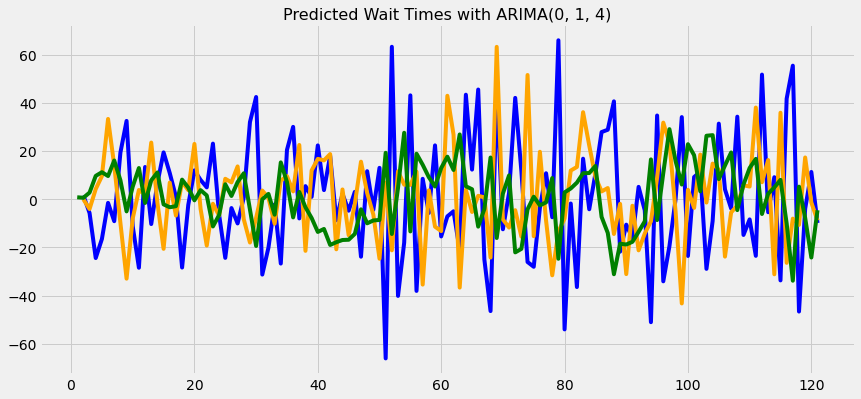

In [87]:
# Plot data.
plt.figure(figsize=(13,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted Wait Times with ARIMA(0, 1, 4)', fontsize=16)
plt.show();

The blue line represents 2019 (train) data; the orange line represents 2021 (test, i.e. actual) data. The green line represents the predicted wait times.

To plot the two time series on the same timeframe, I replaced the respective date indices with a day_number index, beginning on Aug 30 and ending on Oct 31 of the respective years.

The model predicts wait times fairly well for roughly the first 38 days.  After that, it predicts downward and upward spikes about 10 days too soon; the predicted downward spike is also more severe than the actual one. Time series models typically don't forecast well beyond 30-60 days.  Given the further limitations of the data and COVID as a disruptor, I'm satisfied with my model.

Overall, it appears visitors can anticipate shorter wait times in Autumn, 2021 and (likely) until the covid pandemic wanes globally. Alternatively, until park capacity is increased, wait times will remain shorter. 

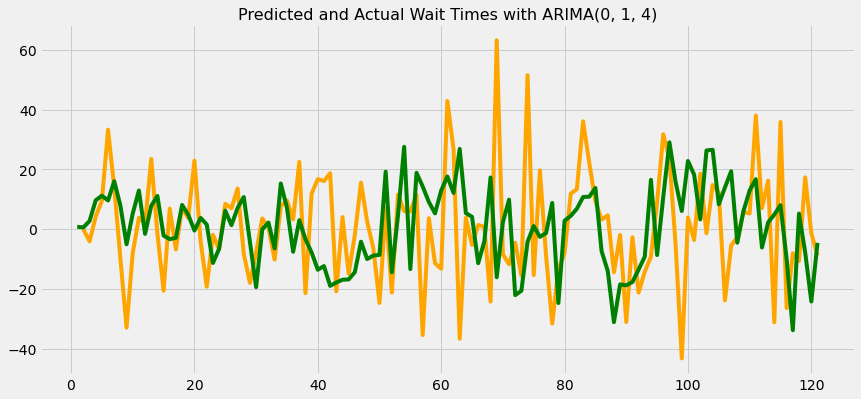

In [88]:
# Plot data.
plt.figure(figsize=(13,6))

# Plot training data.
#plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted and Actual Wait Times with ARIMA(0, 1, 4)', fontsize=16)
plt.show();

Alas, it appears that the model did not do a great job of predicting wait times.  After about 65 days, the model flattened.

In [89]:
adfuller(y_train['avg_daily_wait'])

(-2.663864211313864,
 0.08050277267871558,
 1,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 991.1513602933715)

In [90]:
adfuller(precovid_weekly_3['avg_weekly_wait'])

(-3.111474264290956,
 0.025715612736970015,
 0,
 83,
 {'1%': -3.5117123057187376,
  '5%': -2.8970475206326833,
  '10%': -2.5857126912469153},
 622.6254492430312)

With an alpha of .05 and a p-value of .34, the y_train data are not stationary. The small dataframe size might account for this, given that the larger, weekly data tested immediately above (precovid_weekly_3) are stationary.  However, because of the dataframe's size (n = 63), SARIMAX is not an option for this ride.  It will be an interesting test for Kiliminjaro Safaris and Everest Expeditions (those rides have been operating much longer).

### Mean Absolute Error

In [91]:
#preds_df = pd.DataFrame(arima)
#preds_df.head()

In [92]:
# print(f'Mean absolute error: {preds_df.mae}')
# print(f'Mean squared error: {preds_df.mse}')

Both mean absolute error and mean squared error are low.  This indicates that the model is strong, perhaps because of the high degree of autocorrelation.

In [93]:
# print(preds.summary())

In [94]:
# Convert preds to df column for app

### Option 3:  SARIMAX

Since the custom model failed so dismally for Na'vi River Journey, I'm not attempting it again.

In [95]:
y_train

,avg_daily_wait
day_number,
1,93.277311
2,94.833333
3,89.110169
4,64.708333
5,48.196721
...,...
117,231.200000
118,184.612069
119,180.648148


## Choose Best Model

In [96]:
# Calculate MSE and MAE for null model
# Remember, the null model is that guests will wait 79 minutes to ride this ride.

In [97]:
y_test

,avg_daily_wait
day_number,
1,16.818182
2,16.764706
3,12.688679
4,16.904762
5,26.435185
...,...
117,127.727273
118,117.090164
119,134.393939


In [98]:
# Create dataframe with null_wait and avg_daily_wait so I can calculate MAE and MSE

both_models['null_wait'] = 79
both_models = both_models[['null_wait', 'avg_daily_wait']]
both_models.head()

# Note: the first 'avg_daily_wait' field is for 2021

,null_wait,avg_daily_wait
day_number,,
1,79,16.818182
2,79,16.764706
3,79,12.688679
4,79,16.904762
5,79,26.435185


In [99]:
# MSE and MAE for null model

both_models['null_diff_sq'] = (both_models['null_wait'] - both_models['avg_daily_wait']) ** 2
both_models['abs_null_diff'] = abs(both_models['null_wait'] - both_models['avg_daily_wait'])
null_mse = (both_models['null_diff_sq']).sum()

print(f"Null MSE = {null_mse}")

null_mae = (both_models['abs_null_diff']).sum() / len(both_models)
print(f'Null MAE = {null_mae}')

both_models.head()

Null MSE = 161674.95736099343
Null MAE = 30.71836530202421


,null_wait,avg_daily_wait,null_diff_sq,abs_null_diff
day_number,,,,
1,79,16.818182,3866.578512,62.181818
2,79,16.764706,3873.231834,62.235294
3,79,12.688679,4397.191260,66.311321
4,79,16.904762,3855.818594,62.095238
5,79,26.435185,2763.059757,52.564815


In [100]:
# ARIMA
# RMSEs range from .114 to .162.

In [101]:
# MSE and MAE for ARIMA
# Add column with ARIMA predictions
preds_df = pd.DataFrame(preds)
preds_df.columns = ['pred_off']

preds_df['pred_sq'] = (preds_df['pred_off'])**2
arima_mse = (preds_df['pred_sq']).sum()

preds_df['preds_abs'] = abs(preds_df['pred_off'])
arima_mae = (preds_df['preds_abs']).sum() / len(preds_df)

print(f"ARIMA MSE = {arima_mse}")
print(f"ARIMA MAE = {arima_mae}")

ARIMA MSE = 20561.43511265505
ARIMA MAE = 10.710302946898091


The ARIMA MSE is far better than the null model, by more than tenfold. The ARIMA MAE is 5 times lower.

# Pickle

In [102]:
flight_arima = arima

In [103]:
with open('models/flight_arima.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(flight_arima, pickle_out)